In [3]:
import os
import json
import sys
import glob

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd

sys.path.append("..")
import util

%matplotlib inline

In [89]:
direcs = sorted(glob.glob("../run/onset_channels/INC_*"))
thresholds = np.array([float(os.path.split(d)[1][4:]) for d in direcs])
ref = 5.0
iref = np.where(thresholds == ref)[0][0]
sids = range(1, 51)

## Load data

In [90]:
results = []

for direc, threshold in zip(direcs, thresholds):
    for sid in sids:
        with open(os.path.join(direc, f"id{sid:03d}.json")) as fh:
            data = json.load(fh)
        for sdata in data:
            rid = sdata['rid']
            for ch in sdata['channels_nonseizing']:
                results.append({'sid': sid, 'rid': rid, 'channel': ch, 'threshold': threshold,
                                'seizing': False, 'time': np.nan})
            for ch, time in zip(sdata['channels_seizing'], sdata['onset_times']):
                results.append({'sid': sid, 'rid': rid, 'channel': ch, 'threshold': threshold,
                                'seizing': True, 'time': time})

df = pd.DataFrame(results)

## Analyze data

In [91]:
nseizing = []
for thr in thresholds:    
    dff = df[df.threshold == thr]
    nseizing.append(np.mean(dff.seizing))
    print(f"{thr:7.4f}  {len(dff)} {np.mean(dff.seizing):.2f}")
nseizing = np.array(nseizing)

 2.5000  14571 0.77
 3.1498  14571 0.74
 3.9685  14571 0.70
 5.0000  14571 0.66
 6.2996  14571 0.63
 7.9370  14571 0.59
10.0000  14571 0.55
12.5992  14571 0.52
15.8740  14571 0.49
20.0000  14571 0.45


In [92]:
df = df.sort_values(by=['sid', 'rid', 'threshold', 'channel'])

In [93]:
dfref = df[df.threshold == thresholds[iref]]
dfref = dfref.reset_index()
mask = ~dfref.time.isna()

In [113]:
INF = 1000000 # Because np.percentile does not work well with np.inf

tdif = np.zeros((3, len(thresholds)))

for i, thr in enumerate(thresholds):
    dff = df[df.threshold == thr].reset_index()
    dt = dff[mask].time - dfref[mask].time
    
    dt[dt.isna()] = INF if thr > thresholds[iref] else -INF
    tdif[:, i] = np.percentile(dt, [10, 50, 90])

## Figure

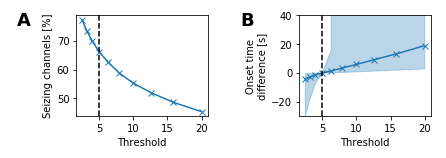

In [118]:
fig = plt.figure(figsize=(6, 2))

gs = gridspec.GridSpec(1, 2, left=0.16, right=0.98, bottom=0.24, top=0.94, wspace=0.7)

ax1 = plt.subplot(gs[0])
plt.plot(thresholds, 100*nseizing, 'x-')
plt.xlabel("Threshold")
plt.ylabel("Seizing channels [%]")
plt.axvline(thresholds[iref], color='k', ls='--')

ax2 = plt.subplot(gs[1])
plt.plot(thresholds, tdif[1, :], 'x-', color='tab:blue')
plt.fill_between(thresholds, tdif[0, :], tdif[2, :], color='tab:blue', alpha=0.3)
plt.xlabel("Threshold")
plt.ylabel("Onset time\ndifference [s]")
plt.axvline(thresholds[iref], color='k', ls='--')
plt.ylim(-30, 40)

bg = util.plot.Background(visible=False)
util.plot.add_panel_letters(fig, [ax1, ax2], fontsize=18, xpos=-0.45, ypos=0.9)

plt.savefig("./img/onset-detection-threshold.pdf")